In [8]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
#torch.multiprocessing.set_start_method("spawn")
import pre_vgg
from sklearn.model_selection import KFold
import copy

import os
import numpy as np
import pandas as pd
from utils import progress_bar
from skimage import transform as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
BASE_dir = 'data/processed/'

train = pd.read_json(BASE_dir + 'train.json')
test = pd.read_json(BASE_dir + 'test.json')

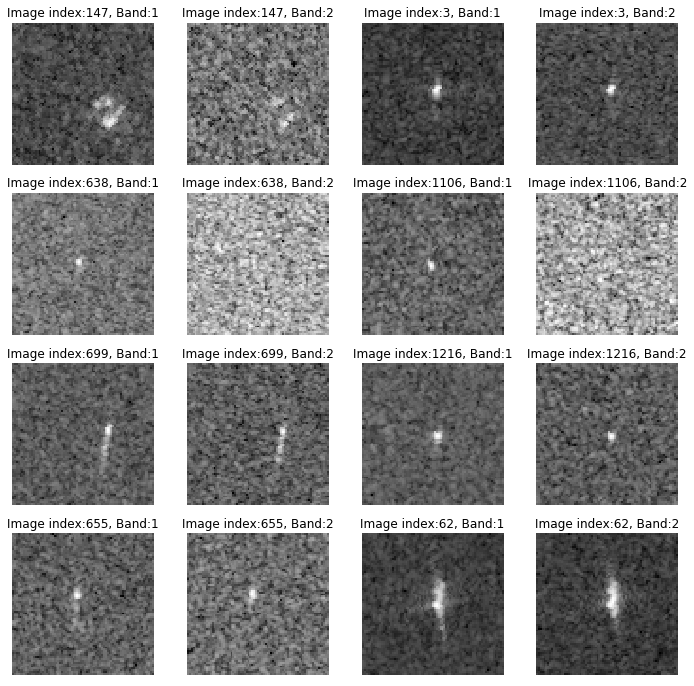

In [3]:
len(train) # 1604 obs
train.head(3)
#randomly draw some of them

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(4,4)

index = np.random.choice(list(range(len(train))),size=8, replace=False)
for num,i in enumerate(index):
    for j in range(2):
        ax = plt.subplot(gs[num*2+j])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title('Image index:%d, Band:%d' % (i, j%2+1))
        ax.set_aspect('equal')
        plt.imshow(np.array(train.iloc[i,j%2]).reshape(75,75))

In [32]:
#prepare data
use_cuda= True if torch.cuda.is_available() else False
#use_cuda =False
#dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor 
dtype = torch.FloatTensor 
data=  pd.read_json(BASE_dir + 'train.json')

class iceberg_dataset(Dataset):
    def __init__(self, data, label, transform=None, test=False): #data: 1604 * 3 *75* 75
        self.data =data
        self.label = torch.from_numpy(label).type(torch.LongTensor)
        self.transform= transform
        self.test= test
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img, label=  self.data[idx], self.label[idx]
        if self.transform is not None:
            #Random Horizontal Flip and Vertical Flip 
            #https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
            if self.test is False:
                if np.random.uniform()>0.5:
                    img = np.flip(img,axis=1).copy()
                if np.random.uniform()>0.5:
                    img = np.flip(img,axis=2).copy()
                #scale = np.exp(np.random.uniform(np.log(1/1.1), np.log(1.1)))
                #aug = tf.AffineTransform(scale= (scale, scale))
                #img = tf.warp(img, inverse_map=aug)
#                 angle = np.random.uniform(0,360)
#                 img = tf.rotate(img,angle=angle,resize=False)
#                 angle = np.random.choice([0, 30,60],size=1)
#                 img = tf.rotate(img,angle=angle,resize=False)
                rotate = np.random.randint(4, size=1)
                if rotate:
                    img = np.rot90(img,k=rotate,axes=(1,2)).copy()
            temp = []
            for i in img:
                temp.append(tf.rescale(i,224/75,mode='constant'))
            img = np.stack(temp)
            img = torch.from_numpy(img).type(dtype)
            img = self.transform(img)

        return img, label

def stack(row):
    return np.stack(row[['c1','c2','c3']]).reshape(3,75,75)

def raw_to_numpy(data):
    img = []
    data['c1'] = data['band_1'].apply(np.array)
    data['c2'] = data['band_2'].apply(np.array)
    data['c3'] = (data['c1'] + data['c2'])/2
#     data['c3'] = (data['c1'] + data['c2'])/2
    for _, row in data.iterrows():
        img.append(stack(row))
    return np.stack(img)

def transform_compute(img):
    train_mean = img.mean(axis=(0,2,3))
    train_std = img.std(axis=(0,2,3))
    return train_mean, train_std

def data_aug(X, y):
    
    X_rot_30 = []
    X_rot_60 = [] 
    X_h = np.flip(X, 3)
    X_v = np.flip(X, 2)
    for i in X:
        X_rot_30.append(tf.rotate(i,angle=30,resize=False))
        X_rot_60.append(tf.rotate(i,angle=60,resize=False))
        
    X_rot_30 = np.stack(X_rot_30)
    X_rot_60 = np.stack(X_rot_60)
    ch_y = np.concatenate((y,y,y,y,y))
    ch_X = np.concatenate((X, X_h, X_v, X_rot_30, X_rot_60))
    return ch_X, ch_y


train_X = raw_to_numpy(data)#.transpose(0,2,3,1)
train_X.shape     #1604 * 3 *75* 75   N*c*H*W
train_y = data['is_iceberg'].values # if iceberg then 1

In [33]:
# train_index=list(range(1300))
# val_index= list(range(1300,1604))
train_index=list(range(304,1604)) 
val_index= list(range(304))
# train_X[train_index].shape

# data.inc_angle = data.inc_angle.map(lambda x: 0.0 if x == 'na' else x)
# train_index = np.where(data.inc_angle > 0)[0]
# val_index = np.where(data.inc_angle <= 0)[0]

# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X))
train_mean, train_std = transform_compute(train_X[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])

train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

## add augmentation 
# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X))

# train_X_af,train_y_af = data_aug(train_X[train_index], train_y[train_index])
# train_mean, train_std = transform_compute(train_X_af)
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])

# train_dataset = iceberg_dataset(data= train_X_af, label=train_y_af, transform=train_transform)
# val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

# train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
#                           shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

In [30]:
torch.cuda.is_available()
torch.from_numpy(train_X).type(torch.FloatTensor)[1].shape
train_X[1]
use_cuda
# for i in train_loader:
#     print(i.size())
#     break

(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 22

AttributeError: 'list' object has no attribute 'size'

(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 22

In [31]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        #scheduler.step()
        scheduler.step(acc)
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >=best_acc:
                best_acc= acc
                e_s = 0
                torch.save(net.state_dict(), 'vgg_acc.pth')
#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_acc,i

    return best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total

In [7]:
vgg16 = pre_vgg.vgg16_bn(pretrained=True)
for param in vgg16.parameters():
    print(param.)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/FDSM_lhn/.torch/models/vgg16_bn-6c64b313.pth
100.0%


Parameter containing:
(0 ,0 ,.,.) = 
  8.2833e-02  2.7968e-02  7.7096e-02
  4.9341e-02 -3.3441e-02  1.9572e-02
  8.0300e-02  7.7076e-02  8.3349e-02

(0 ,1 ,.,.) = 
 -4.4296e-02 -1.7748e-01 -4.8706e-02
 -1.1003e-01 -2.7530e-01 -1.3474e-01
 -5.9982e-03 -6.1375e-02  1.6822e-02

(0 ,2 ,.,.) = 
  2.7480e-02 -6.6769e-02  4.3955e-02
 -2.6662e-02 -1.4995e-01 -3.3615e-02
  5.2778e-02  1.7143e-02  8.6744e-02
     ⋮ 

(1 ,0 ,.,.) = 
 -1.2628e-02  3.0218e-02 -2.6930e-02
 -1.3764e-02  1.1993e-01 -6.6263e-03
 -2.6019e-02 -8.3535e-03 -3.9197e-02

(1 ,1 ,.,.) = 
 -4.0557e-02  1.3983e-02 -5.4278e-02
  1.5412e-02  1.8198e-01  1.7598e-02
 -1.7032e-02  1.1284e-02 -2.4226e-02

(1 ,2 ,.,.) = 
 -6.5683e-02  5.9252e-02 -5.3020e-02
  3.8278e-02  2.7292e-01  5.9491e-02
 -4.1218e-02  3.6159e-02 -3.0478e-02
     ⋮ 

(2 ,0 ,.,.) = 
  1.4962e-06 -1.1430e-06  1.2536e-06
 -1.0341e-06 -5.1964e-06 -1.1568e-06
  2.5825e-06  2.5617e-07  1.6146e-06

(2 ,1 ,.,.) = 
  3.0030e-06  4.2831e-07  2.3388e-06
  2.8718e-07 -3.6006e

Parameter containing:
( 0 , 0 ,.,.) = 
 -4.7228e-03  6.1350e-03  9.2539e-03
 -9.5013e-04 -1.2995e-02 -9.7248e-03
 -1.1794e-02 -1.9362e-02 -1.6484e-02

( 0 , 1 ,.,.) = 
  3.1288e-02  1.9738e-02  3.5423e-02
  1.1064e-02 -7.8965e-03  2.7237e-02
 -3.0856e-03  7.9598e-03  8.3558e-03

( 0 , 2 ,.,.) = 
  1.7003e-02  8.9700e-03  8.6330e-03
 -8.4372e-03 -1.7460e-02 -2.1673e-02
 -4.5785e-04 -1.2148e-02 -1.4268e-02
    ... 

( 0 ,509,.,.) = 
 -1.4422e-02 -2.2441e-02 -2.2388e-02
  1.1210e-02  3.2948e-03 -2.4308e-03
 -5.0929e-03 -5.1824e-03 -1.0678e-02

( 0 ,510,.,.) = 
 -1.9068e-02 -1.8938e-02 -2.4867e-02
 -6.0156e-03 -8.2365e-03 -1.3951e-02
 -1.1423e-02 -8.9651e-03 -1.3677e-02

( 0 ,511,.,.) = 
 -5.0744e-03 -9.5685e-03 -5.1837e-02
 -7.4568e-03 -8.1368e-03 -4.6485e-02
  5.0472e-03  1.2508e-02 -1.4355e-03
      ⋮  

( 1 , 0 ,.,.) = 
 -2.0506e-02 -2.4464e-02 -3.3749e-02
 -4.1953e-02 -2.2862e-02 -2.4604e-02
 -2.4789e-02 -1.8484e-02 -2.7139e-02

( 1 , 1 ,.,.) = 
 -3.1903e-02 -1.6090e-02 -2.6388e-02
 -

Parameter containing:
-5.1433e-03  1.4447e-03 -2.0302e-03  ...  -4.2616e-03  3.2284e-03  5.4096e-03
-1.4533e-03  3.6960e-03  4.0049e-04  ...  -3.0048e-03  1.6141e-03  1.5717e-03
 1.1294e-04  1.3715e-03  1.5156e-03  ...   4.3445e-03 -4.8541e-04  3.7755e-03
                ...                   ⋱                   ...                
-3.9146e-03 -2.8939e-03 -4.4591e-03  ...   2.3788e-04  1.6971e-03  1.6045e-04
-1.4698e-03 -4.5146e-03 -5.3634e-03  ...   1.6210e-03  7.7839e-04 -4.4860e-03
-1.8253e-03  2.4467e-03  2.3490e-04  ...  -7.2082e-03 -4.5467e-03  7.9109e-04
[torch.FloatTensor of size 4096x25088]

Parameter containing:
 4.2639e-02
 7.1186e-03
 1.0525e-01
     ⋮     
 2.1179e-02
-5.8841e-02
 1.8548e-02
[torch.FloatTensor of size 4096]

Parameter containing:
 2.1287e-02  5.8711e-04  4.7286e-03  ...  -1.1499e-02  7.1668e-03  1.2486e-02
 4.6511e-03 -2.3969e-02  6.1767e-03  ...   1.0963e-02  8.7579e-04  1.8766e-02
 1.3253e-02 -3.6758e-03  8.6062e-03  ...   1.0737e-02  4.6565e-03  5.1872e

In [37]:
#vgg16 = pre_vgg.vgg16_bn(pretrained=True)
vgg16_bn = copy.deepcopy(vgg16)
for param in vgg16_bn.parameters():
    param.requires_grad =False
    
vgg16_bn.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.7),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.7),
            nn.Linear(4096, 2),
        )

net= vgg16_bn

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here   
#(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
optimizer = optim.SGD(net.classifier.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0002, nesterov= True)
#scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience =10,min_lr= 0.0001)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

train(epoch=250)


This is epoch:1
[============ 41/41 ==========>]  Step: 86ms | Tot: 5s407ms | Loss: 0.897 | Acc: 53.923% (701/1300))
[============ 5/5 =======>.....]  Step: 153ms | Tot: 759ms | Loss: 0.742 | Acc: 55.263% (168/304)

This is epoch:2
[============ 41/41 ==========>]  Step: 85ms | Tot: 5s451ms | Loss: 0.768 | Acc: 64.000% (832/1300))
[============ 5/5 =======>.....]  Step: 154ms | Tot: 679ms | Loss: 0.433 | Acc: 78.947% (240/304)

This is epoch:3
[============ 41/41 ==========>]  Step: 86ms | Tot: 5s652ms | Loss: 0.580 | Acc: 71.462% (929/1300))
[============ 5/5 =======>.....]  Step: 152ms | Tot: 824ms | Loss: 0.449 | Acc: 75.987% (231/304)

This is epoch:4
[============ 41/41 ==========>]  Step: 86ms | Tot: 5s571ms | Loss: 0.525 | Acc: 73.385% (954/1300))
[============ 5/5 =======>.....]  Step: 152ms | Tot: 796ms | Loss: 0.404 | Acc: 79.276% (241/304)

This is epoch:5
[============ 41/41 ==========>]  Step: 84ms | Tot: 5s378ms | Loss: 0.509 | Acc: 74.077% (963/1300))
[============ 5/5 

[============ 41/41 ==========>]  Step: 86ms | Tot: 5s356ms | Loss: 0.333 | Acc: 84.000% (1092/1300))
[============ 5/5 =======>.....]  Step: 152ms | Tot: 737ms | Loss: 0.337 | Acc: 83.553% (254/304)

This is epoch:39
[============ 41/41 ==========>]  Step: 86ms | Tot: 5s414ms | Loss: 0.316 | Acc: 84.615% (1100/1300))
[============ 5/5 =======>.....]  Step: 153ms | Tot: 679ms | Loss: 0.335 | Acc: 82.566% (251/304)

This is epoch:40
[============ 41/41 ==========>]  Step: 85ms | Tot: 5s450ms | Loss: 0.309 | Acc: 85.615% (1113/1300))
[============ 5/5 =======>.....]  Step: 152ms | Tot: 702ms | Loss: 0.330 | Acc: 81.908% (249/304)

This is epoch:41
[============ 41/41 ==========>]  Step: 87ms | Tot: 5s432ms | Loss: 0.315 | Acc: 83.846% (1090/1300))
[============ 5/5 =======>.....]  Step: 153ms | Tot: 676ms | Loss: 0.330 | Acc: 82.566% (251/304)

This is epoch:42
[============ 41/41 ==========>]  Step: 84ms | Tot: 5s251ms | Loss: 0.318 | Acc: 84.923% (1104/1300))
[============ 5/5 =======>

Process Process-1167:
Process Process-1165:
Process Process-1166:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i]

KeyboardInterrupt: 

KeyboardInterrupt
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 42, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/skimage/transform/_geometric.py", line 688, in estimate
    H = np.dot(np.linalg.inv(dst_matrix), np.dot(H, src_matrix))
KeyboardInterrupt
  File "<ipython-input-32-84b71ab8e05e>", line 40, in __getitem__
    temp.append(tf.rescale(i,224/75,mode='constant'))
  File "/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py", line 205, in rescale
    clip=clip, preserve_range=preserve_range)
  File "/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py", line 131, in resize
    tform.estimate(src_corners, dst_corners)
  File "/usr/local/lib/python3.5/dist-packages/skimage/transform/_geometric.py", line 688, in estimate
    H = np.dot(np.linalg.inv(dst_matrix), np.dot(H, src_matrix))
  File "/usr/local/lib/python3.5/dist-packages/numpy/lina

In [76]:
##For continue training
resnet34 = resnet.resnet34(num_classes=2)
net= resnet34
net.load_state_dict(torch.load('save_resnet34_acc.pth'))

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00012, nesterov= True)
scheduler = MultiStepLR(optimizer, [50,100], gamma=0.1)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

#train(epoch=150)


test_set = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test_set)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)
result = []
for i in range(10):
    train(epoch=1)

    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    result.append(np.concatenate(prob))


This is epoch:1
[=================== 41/41 =================>.]  Step: 65ms | Tot: 3s272ms | Loss: 0.175 | Acc: 92.538% (1203/1300)
[=================== 5/5 ============>........]  Step: 33ms | Tot: 171ms | Loss: 0.194 | Acc: 93.092% (283/304)
[=================== 132/132 ================>]  Step: 33ms | Tot: 5s848ms

This is epoch:1
[=================== 41/41 =================>.]  Step: 65ms | Tot: 3s282ms | Loss: 0.169 | Acc: 92.846% (1207/1300)
[=================== 5/5 ============>........]  Step: 34ms | Tot: 168ms | Loss: 0.195 | Acc: 92.434% (281/304)
[=================== 132/132 ================>]  Step: 32ms | Tot: 5s827ms

This is epoch:1
[=================== 41/41 =================>.]  Step: 65ms | Tot: 3s279ms | Loss: 0.176 | Acc: 92.154% (1198/1300)
[=================== 5/5 ============>........]  Step: 33ms | Tot: 170ms | Loss: 0.194 | Acc: 92.763% (282/304)
[=================== 132/132 ================>]  Step: 33ms | Tot: 5s807ms

This is epoch:1
[=================== 41

In [75]:
test_set = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test_set)
test_X.shape

(8424, 3, 75, 75)

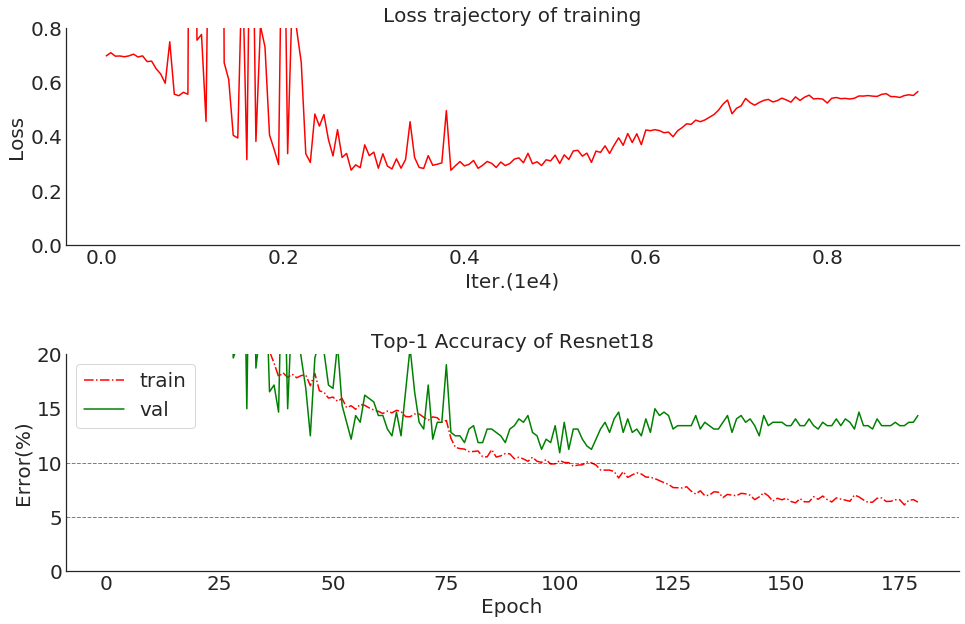

In [38]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


# fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.plot([i * 0.005 for i in range(1,len(train_data['val_loss_hist'])+1)],train_data['val_loss_hist'],color='red')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)',ylim=(0,0.8))

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet34',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

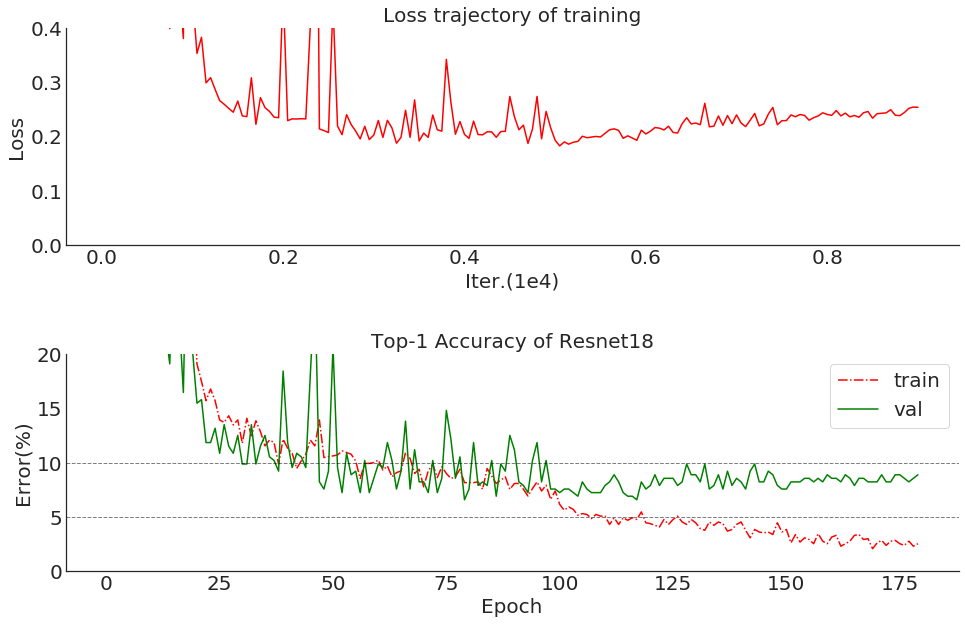

In [28]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


# fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.plot([i * 0.005 for i in range(1,len(train_data['val_loss_hist'])+1)],train_data['val_loss_hist'],color='red')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)',ylim=(0,0.4))

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet18',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

In [19]:
#Bayesian optimization

from bayes_opt import BayesianOptimization

opt_hist=[]
def resnet_evaluate(lr,wd):
    global net,criterion, optimizer,scheduler
    
    net = resnet.resnet18(num_classes=2)

    criterion = nn.CrossEntropyLoss()

    #Adam does not perform so good here
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd, nesterov= True)
    scheduler = MultiStepLR(optimizer, [30,60,90], gamma=0.1)
    #5e-3 86
    if use_cuda:
        criterion.cuda()
        net.cuda()
    result = train(epoch=120,early_stopping=25)
    opt_hist.append(result)
    return result[0]

resnetOB = BayesianOptimization(resnet_evaluate, {'lr': (0.0001, 0.1),
                                                   'wd':(0.0001, 0.1)
                                                 })

resnetOB.explore({
'lr': (0.1, 0.01,0.001,0.1, 0.01,0.001),
'wd':(0.0001, 0.0001,0.0001,0.001,0.002,0.003)
})



resnetOB.maximize(init_points=3, n_iter=10,acq='ei', xi=0.05)

Initialization
-----------------------------------------------------
 Step |   Time |      Value |        lr |        wd | 

This is epoch:1
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s44ms | Loss: 3.181 | Acc: 57.462% (747/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 45.076 | Acc: 35.526% (108/304)

This is epoch:2
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s15ms | Loss: 0.792 | Acc: 61.154% (795/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.824 | Acc: 46.711% (142/304)

This is epoch:3
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s27ms | Loss: 0.662 | Acc: 64.385% (837/1300))
[=================== 5/5 ============>........]  Step: 143ms | Tot: 632ms | Loss: 0.670 | Acc: 55.592% (169/304)

This is epoch:4
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s4ms | Loss: 0.744 | Acc: 62.923% (818/1300)0)


[=================== 5/5 ============>........]  Step: 143ms | Tot: 633ms | Loss: 0.297 | Acc: 86.842% (264/304)

This is epoch:66
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s29ms | Loss: 0.237 | Acc: 90.538% (1177/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.307 | Acc: 85.526% (260/304)

This is epoch:67
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s26ms | Loss: 0.243 | Acc: 90.154% (1172/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.318 | Acc: 84.539% (257/304)

This is epoch:68
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s20ms | Loss: 0.249 | Acc: 89.385% (1162/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.299 | Acc: 86.184% (262/304)

This is epoch:69
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s33ms | Loss: 0.245 | Acc: 90.615% (1178/1300))
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.250 | Acc: 88.158% (268/304)

This is epoch:20
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s45ms | Loss: 0.184 | Acc: 93.077% (1210/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 630ms | Loss: 0.394 | Acc: 82.566% (251/304)

This is epoch:21
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.209 | Acc: 91.154% (1185/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.571 | Acc: 76.316% (232/304)

This is epoch:22
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.208 | Acc: 91.692% (1192/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.444 | Acc: 83.224% (253/304)

This is epoch:23
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s41ms | Loss: 0.191 | Acc: 92.077% (1197/1300))
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.300 | Acc: 86.184% (262/304)

This is epoch:31
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s45ms | Loss: 0.178 | Acc: 93.462% (1215/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.346 | Acc: 84.539% (257/304)

This is epoch:32
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s41ms | Loss: 0.182 | Acc: 92.923% (1208/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.317 | Acc: 87.171% (265/304)

This is epoch:33
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s40ms | Loss: 0.177 | Acc: 93.154% (1211/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.332 | Acc: 84.868% (258/304)

This is epoch:34
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s25ms | Loss: 0.175 | Acc: 93.462% (1215/1300))
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.258 | Acc: 90.461% (275/304)

This is epoch:42
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s47ms | Loss: 0.213 | Acc: 91.077% (1184/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.246 | Acc: 91.118% (277/304)

This is epoch:43
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s52ms | Loss: 0.209 | Acc: 91.000% (1183/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 639ms | Loss: 0.269 | Acc: 88.816% (270/304)

This is epoch:44
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s37ms | Loss: 0.211 | Acc: 91.769% (1193/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.287 | Acc: 87.171% (265/304)

This is epoch:45
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.200 | Acc: 92.000% (1196/1300))
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.589 | Acc: 63.816% (194/304)

This is epoch:4
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s46ms | Loss: 0.443 | Acc: 79.923% (1039/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.496 | Acc: 71.053% (216/304)

This is epoch:5
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s38ms | Loss: 0.426 | Acc: 80.462% (1046/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.473 | Acc: 74.342% (226/304)

This is epoch:6
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s39ms | Loss: 0.389 | Acc: 83.077% (1080/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.485 | Acc: 72.697% (221/304)

This is epoch:7
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s43ms | Loss: 0.376 | Acc: 83.385% (1084/1300))
[=======

[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.708 | Acc: 33.553% (102/304)

This is epoch:18
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s18ms | Loss: 0.694 | Acc: 52.385% (681/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.740 | Acc: 33.553% (102/304)

This is epoch:19
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s12ms | Loss: 0.698 | Acc: 48.846% (635/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 633ms | Loss: 0.683 | Acc: 66.447% (202/304)

This is epoch:20
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s11ms | Loss: 0.695 | Acc: 50.231% (653/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.687 | Acc: 66.447% (202/304)

This is epoch:21
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s26ms | Loss: 0.696 | Acc: 51.308% (667/1300))
[=======

[=================== 41/41 =================>.]  Step: 427ms | Tot: 14s989ms | Loss: 0.397 | Acc: 83.615% (1087/1300)
[=================== 5/5 ============>........]  Step: 145ms | Tot: 639ms | Loss: 0.783 | Acc: 56.908% (173/304)

This is epoch:51
[=================== 41/41 =================>.]  Step: 427ms | Tot: 14s989ms | Loss: 0.388 | Acc: 82.923% (1078/1300)
[=================== 5/5 ============>........]  Step: 145ms | Tot: 636ms | Loss: 0.495 | Acc: 77.303% (235/304)

This is epoch:52
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s9ms | Loss: 0.409 | Acc: 82.308% (1070/1300)0)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.507 | Acc: 75.658% (230/304)

This is epoch:53
[=================== 41/41 =================>.]  Step: 429ms | Tot: 14s987ms | Loss: 0.383 | Acc: 84.385% (1097/1300)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.511 | Acc: 74.013% (225/304)

This is epoch:54
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s33ms | Loss: 0.264 | Acc: 90.077% (1171/1300))
[=================== 5/5 ============>........]  Step: 143ms | Tot: 633ms | Loss: 0.335 | Acc: 85.526% (260/304)

This is epoch:43
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s45ms | Loss: 0.279 | Acc: 89.385% (1162/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.279 | Acc: 89.803% (273/304)

This is epoch:44
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s33ms | Loss: 0.268 | Acc: 89.923% (1169/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.369 | Acc: 83.882% (255/304)

This is epoch:45
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s53ms | Loss: 0.264 | Acc: 90.385% (1175/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.515 | Acc: 75.987% (231/304)

This is epoch:46
[===

[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.559 | Acc: 66.447% (202/304)

This is epoch:30
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s24ms | Loss: 0.439 | Acc: 80.692% (1049/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.826 | Acc: 51.316% (156/304)

This is epoch:31
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s16ms | Loss: 0.441 | Acc: 80.077% (1041/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 633ms | Loss: 0.592 | Acc: 66.776% (203/304)

This is epoch:32
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s10ms | Loss: 0.399 | Acc: 83.308% (1083/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.469 | Acc: 74.671% (227/304)

This is epoch:33
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s27ms | Loss: 0.370 | Acc: 84.615% (1100/1300))
[===

[=================== 5/5 ============>........]  Step: 145ms | Tot: 631ms | Loss: 0.261 | Acc: 89.803% (273/304)

This is epoch:95
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s13ms | Loss: 0.198 | Acc: 92.308% (1200/1300))
[=================== 5/5 ============>........]  Step: 148ms | Tot: 641ms | Loss: 0.270 | Acc: 89.803% (273/304)

This is epoch:96
[=================== 41/41 =================>.]  Step: 427ms | Tot: 14s997ms | Loss: 0.189 | Acc: 92.923% (1208/1300)
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.292 | Acc: 88.487% (269/304)

This is epoch:97
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s12ms | Loss: 0.205 | Acc: 92.462% (1202/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.283 | Acc: 88.487% (269/304)

This is epoch:98
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s11ms | Loss: 0.203 | Acc: 92.000% (1196/1300))
[===

[=================== 5/5 ============>........]  Step: 144ms | Tot: 632ms | Loss: 0.715 | Acc: 46.382% (141/304)

This is epoch:5
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s37ms | Loss: 0.541 | Acc: 71.615% (931/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 630ms | Loss: 0.784 | Acc: 54.276% (165/304)

This is epoch:6
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s27ms | Loss: 0.524 | Acc: 73.385% (954/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.737 | Acc: 44.079% (134/304)

This is epoch:7
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s32ms | Loss: 0.471 | Acc: 77.769% (1011/1300)
[=================== 5/5 ============>........]  Step: 147ms | Tot: 638ms | Loss: 0.843 | Acc: 40.461% (123/304)

This is epoch:8
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s39ms | Loss: 0.462 | Acc: 79.000% (1027/1300))
[==========

[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.287 | Acc: 87.500% (266/304)

This is epoch:70
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s41ms | Loss: 0.175 | Acc: 93.154% (1211/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.284 | Acc: 87.829% (267/304)

This is epoch:71
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s39ms | Loss: 0.184 | Acc: 92.692% (1205/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.290 | Acc: 87.500% (266/304)
   12 | 19m43s |   89.80263 |    0.0992 |    0.0027 | 

This is epoch:1
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s29ms | Loss: 1.412 | Acc: 64.846% (843/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.848 | Acc: 47.368% (144/304)

This is epoch:2
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15

[=================== 5/5 ============>........]  Step: 144ms | Tot: 638ms | Loss: 0.292 | Acc: 88.487% (269/304)

This is epoch:64
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s55ms | Loss: 0.176 | Acc: 93.308% (1213/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.287 | Acc: 86.842% (264/304)

This is epoch:65
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s34ms | Loss: 0.171 | Acc: 93.846% (1220/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 631ms | Loss: 0.272 | Acc: 88.158% (268/304)

This is epoch:66
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s18ms | Loss: 0.160 | Acc: 93.692% (1218/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.271 | Acc: 88.158% (268/304)

This is epoch:67
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s16ms | Loss: 0.169 | Acc: 93.231% (1212/1300))
[===

[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s10ms | Loss: 0.336 | Acc: 83.846% (1090/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.675 | Acc: 69.408% (211/304)

This is epoch:48
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s4ms | Loss: 0.329 | Acc: 84.154% (1094/1300)0)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 636ms | Loss: 0.321 | Acc: 86.842% (264/304)

This is epoch:49
[=================== 41/41 =================>.]  Step: 428ms | Tot: 14s998ms | Loss: 0.338 | Acc: 84.308% (1096/1300)
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.352 | Acc: 84.868% (258/304)

This is epoch:50
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s10ms | Loss: 0.301 | Acc: 87.231% (1134/1300))
[=================== 5/5 ============>........]  Step: 143ms | Tot: 633ms | Loss: 0.321 | Acc: 85.197% (259/304)

This is epoch:51
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s38ms | Loss: 0.219 | Acc: 90.846% (1181/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.668 | Acc: 68.421% (208/304)

This is epoch:22
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s40ms | Loss: 0.221 | Acc: 91.538% (1190/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.249 | Acc: 91.118% (277/304)

This is epoch:23
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s40ms | Loss: 0.193 | Acc: 92.769% (1206/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.301 | Acc: 86.513% (263/304)

This is epoch:24
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s32ms | Loss: 0.225 | Acc: 91.154% (1185/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 636ms | Loss: 0.363 | Acc: 85.855% (261/304)

This is epoch:25
[===

[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s38ms | Loss: 0.072 | Acc: 97.846% (1272/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.345 | Acc: 86.842% (264/304)

This is epoch:40
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s35ms | Loss: 0.092 | Acc: 96.308% (1252/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 635ms | Loss: 0.359 | Acc: 86.842% (264/304)

This is epoch:41
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s40ms | Loss: 0.079 | Acc: 97.000% (1261/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 634ms | Loss: 0.309 | Acc: 89.145% (271/304)

This is epoch:42
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s40ms | Loss: 0.074 | Acc: 97.615% (1269/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.363 | Acc: 88.158% (268/304)

This is epoch:43
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s46ms | Loss: 0.179 | Acc: 91.923% (1195/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.271 | Acc: 90.461% (275/304)

This is epoch:27
[=================== 41/41 =================>.]  Step: 430ms | Tot: 15s58ms | Loss: 0.186 | Acc: 92.000% (1196/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 637ms | Loss: 0.416 | Acc: 84.868% (258/304)

This is epoch:28
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s48ms | Loss: 0.178 | Acc: 93.385% (1214/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 638ms | Loss: 0.374 | Acc: 84.539% (257/304)

This is epoch:29
[=================== 41/41 =================>.]  Step: 427ms | Tot: 15s63ms | Loss: 0.196 | Acc: 91.077% (1184/1300))
[=================== 5/5 ============>........]  Step: 146ms | Tot: 638ms | Loss: 0.718 | Acc: 73.355% (223/304)

This is epoch:30
[===

[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s28ms | Loss: 0.065 | Acc: 97.615% (1269/1300))
[=================== 5/5 ============>........]  Step: 144ms | Tot: 633ms | Loss: 0.346 | Acc: 86.842% (264/304)

This is epoch:43
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s35ms | Loss: 0.064 | Acc: 98.000% (1274/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.354 | Acc: 86.842% (264/304)

This is epoch:44
[=================== 41/41 =================>.]  Step: 428ms | Tot: 15s45ms | Loss: 0.086 | Acc: 97.462% (1267/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 635ms | Loss: 0.334 | Acc: 88.487% (269/304)

This is epoch:45
[=================== 41/41 =================>.]  Step: 429ms | Tot: 15s48ms | Loss: 0.063 | Acc: 97.846% (1272/1300))
[=================== 5/5 ============>........]  Step: 145ms | Tot: 637ms | Loss: 0.384 | Acc: 85.855% (261/304)

This is epoch:46
[===

In [18]:
out1 = torch.cat((out.data,out.data),1)
out1.size()
# out
criterion(out,y.long())
type(predicted)
type(y.data)
#predicted.eq(y.data).cpu().sum()

torch.cuda.DoubleTensor

In [79]:
net = resnet.resnet34(num_classes=2)
net.load_state_dict(torch.load('save_resnet34_acc.pth'))
net.cuda()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))

[=================== 132/132 ================>]  Step: 33ms | Tot: 5s834ms


In [77]:
k =np.stack(result).mean(axis=0)
# #sub.shape
# result[1].shape
# np.concatenate(prob).shape

In [80]:
sub=pd.DataFrame()
sub['id'] = test_set['id']
sub['is_iceberg'] =  np.concatenate(prob)
sub.shape
sub.to_csv('submission2.csv',index=False)

In [41]:
temp= pd.read_csv('submission3.csv') #0.0001 wd one
sub['is_iceberg2'] = temp['is_iceberg']
sub.corr()

,is_iceberg,is_iceberg2
is_iceberg,1.000000,0.886197
is_iceberg2,0.886197,1.000000


In [11]:
#try dropout 0.5 on the last fc
resnet34 = resnet.resnet34(num_classes=2)
net= resnet34

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here   
#(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov= True)
scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

train(epoch=250)


This is epoch:1
[=================== 41/41 =================>.]  Step: 460ms | Tot: 16s242ms | Loss: 4.618 | Acc: 56.231% (731/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 770ms | Loss: 421.466 | Acc: 50.658% (154/304)

This is epoch:2
[=================== 41/41 =================>.]  Step: 464ms | Tot: 16s191ms | Loss: 2.397 | Acc: 59.308% (771/1300)
[=================== 5/5 ============>........]  Step: 174ms | Tot: 767ms | Loss: 1032.273 | Acc: 49.342% (150/304)

This is epoch:3
[=================== 41/41 =================>.]  Step: 463ms | Tot: 16s228ms | Loss: 1.995 | Acc: 58.154% (756/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 766ms | Loss: 522.733 | Acc: 59.539% (181/304)

This is epoch:4
[=================== 41/41 =================>.]  Step: 469ms | Tot: 16s205ms | Loss: 5.970 | Acc: 52.615% (684/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 9.002 | Acc: 50.000% (152/304)

This

[=================== 5/5 ============>........]  Step: 173ms | Tot: 769ms | Loss: 1.166 | Acc: 54.605% (166/304)

This is epoch:66
[=================== 41/41 =================>.]  Step: 463ms | Tot: 16s185ms | Loss: 0.602 | Acc: 65.538% (852/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 837ms | Loss: 0.596 | Acc: 69.079% (210/304)

This is epoch:67
[=================== 41/41 =================>.]  Step: 463ms | Tot: 16s185ms | Loss: 0.594 | Acc: 64.769% (842/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 772ms | Loss: 0.633 | Acc: 63.487% (193/304)

This is epoch:68
[=================== 41/41 =================>.]  Step: 461ms | Tot: 16s184ms | Loss: 0.610 | Acc: 63.308% (823/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 769ms | Loss: 0.650 | Acc: 68.421% (208/304)

This is epoch:69
[=================== 41/41 =================>.]  Step: 466ms | Tot: 16s189ms | Loss: 0.606 | Acc: 65.077% (846/1300)
[=======

[=================== 5/5 ============>........]  Step: 172ms | Tot: 775ms | Loss: 0.245 | Acc: 89.474% (272/304)  Step: 200ms | Tot: 400ms | Loss: 0.246 | Acc: 88.021% (169/192)

This is epoch:129
[=================== 41/41 =================>.]  Step: 464ms | Tot: 16s203ms | Loss: 0.266 | Acc: 87.154% (1133/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 0.238 | Acc: 91.447% (278/304)  Step: 200ms | Tot: 596ms | Loss: 0.224 | Acc: 91.797% (235/256)

This is epoch:130
[=================== 41/41 =================>.]  Step: 462ms | Tot: 16s211ms | Loss: 0.272 | Acc: 87.923% (1143/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 769ms | Loss: 0.230 | Acc: 90.461% (275/304)

This is epoch:131
[=================== 41/41 =================>.]  Step: 461ms | Tot: 16s205ms | Loss: 0.252 | Acc: 88.000% (1144/1300)
[=================== 5/5 ============>........]  Step: 173ms | Tot: 775ms | Loss: 0.231 | Acc: 90.789% (276/304)

This i

[=================== 41/41 =================>.]  Step: 461ms | Tot: 16s195ms | Loss: 0.239 | Acc: 89.385% (1162/1300)
[=================== 5/5 ============>........]  Step: 171ms | Tot: 769ms | Loss: 0.215 | Acc: 91.776% (279/304)

This is epoch:193
[=================== 41/41 =================>.]  Step: 462ms | Tot: 16s206ms | Loss: 0.239 | Acc: 89.846% (1168/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 0.214 | Acc: 92.434% (281/304)

This is epoch:194
[=================== 41/41 =================>.]  Step: 460ms | Tot: 16s207ms | Loss: 0.230 | Acc: 90.231% (1173/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 0.215 | Acc: 91.447% (278/304)

This is epoch:195
[=================== 41/41 =================>.]  Step: 458ms | Tot: 16s180ms | Loss: 0.230 | Acc: 90.385% (1175/1300)
[=================== 5/5 ============>........]  Step: 172ms | Tot: 768ms | Loss: 0.216 | Acc: 91.447% (278/304)

This is epoch:196


(93.42105263157895, 249)

In [17]:
def train(epoch,early_stopping = None):
    global train_data, lr#,out,y,predicted
    best_acc =0
    val_loss =0
    acc= 0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        scheduler.step(acc)
        #scheduler.step()
        if lr != optimizer.param_groups[0]['lr']:
            print('We change learning rate from %f to %f '%(lr, optimizer.param_groups[0]['lr']))
            lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >=best_acc:
                best_acc= acc
                e_s = 0
                torch.save(net.state_dict(), 'resnet34_acc.pth')
#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_acc,i

    return best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total


#Try different transformation

result_hist=[]
for rou in range(10):
    ran_num = np.random.randint(10000,size=1)
    seed= np.random.RandomState(ran_num)
    spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
    for k,(train_index, val_index) in enumerate(spliter.split(train_X)):
        train_X[train_index].shape

        train_mean, train_std = transform_compute(train_X[train_index])
        train_transform = T.Compose([
            T.Normalize(train_mean, train_std)
        ])

        train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
        val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

        train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                                  shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

        resnet34 = resnet.resnet34(num_classes=2)
        net= resnet34

        criterion = nn.CrossEntropyLoss()

        #Adam does not perform so good here   
        #(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
        optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.00012, nesterov= True)
        #scheduler = MultiStepLR(optimizer, [110,160,200], gamma=0.1)

        #
        scheduler = ReduceLROnPlateau(optimizer, 'max', patience =20)
        #5e-3 86
        if use_cuda:
            criterion.cuda()
            net.cuda()
        #     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
        #     cudnn.benchmark = True   

        result = train(epoch=300,early_stopping=30)
        result_hist.append(result)
        if result[0] >=92 or (rou ==0 and k==0):
            with open("log.txt", "a") as myfile:
                msg = 'At round {}, fold {}, seed {}, we find a good value with acc: {}\n'.format(rou,
                                                            k,ran_num, result[0])
                myfile.write(msg)
            cmd = 'cp resnet34_acc.pth resnet34_save_model/resnet34_acc{}{}.pth'.format(rou,k)
            os.system(cmd)


This is epoch:1
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s262ms | Loss: 3.195 | Acc: 46.610% (598/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 194ms | Loss: 3.415 | Acc: 52.960% (170/321)

This is epoch:2
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s224ms | Loss: 0.918 | Acc: 51.052% (655/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 191ms | Loss: 42.864 | Acc: 42.991% (138/321)

This is epoch:3
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s231ms | Loss: 0.986 | Acc: 50.663% (650/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 79926.629 | Acc: 57.009% (183/321)

This is epoch:4
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s239ms | Loss: 0.846 | Acc: 50.740% (651/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 194ms | Loss: 1.589 | Acc: 42.991% (138/321)

This is epoch:5
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s232ms | Loss: 0.720 | Acc: 54.326% (697/1283)
[============ 6/6 ====

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s245ms | Loss: 0.665 | Acc: 53.313% (684/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.694 | Acc: 50.156% (161/321)

This is epoch:5
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s233ms | Loss: 0.654 | Acc: 52.065% (668/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.694 | Acc: 50.156% (161/321)

This is epoch:6
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s237ms | Loss: 0.669 | Acc: 52.533% (674/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 191ms | Loss: 0.695 | Acc: 50.156% (161/321)

This is epoch:7
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s241ms | Loss: 0.653 | Acc: 54.793% (703/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.699 | Acc: 49.844% (160/321)

This is epoch:8
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s232ms | Loss: 0.671 | Acc: 55.729% (715/1283)
[============ 6/6 ========>....]  Step: 12ms

[============ 6/6 ========>....]  Step: 13ms | Tot: 191ms | Loss: 0.615 | Acc: 61.682% (198/321)

This is epoch:40
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s230ms | Loss: 0.642 | Acc: 56.041% (719/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 189ms | Loss: 0.634 | Acc: 59.502% (191/321)

This is epoch:41
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s233ms | Loss: 0.631 | Acc: 57.677% (740/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 194ms | Loss: 0.601 | Acc: 67.913% (218/321)

This is epoch:42
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s235ms | Loss: 0.605 | Acc: 61.029% (783/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 190ms | Loss: 0.589 | Acc: 62.305% (200/321)

This is epoch:43
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s232ms | Loss: 0.617 | Acc: 56.586% (726/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.605 | Acc: 66.355% (213/321)

This is epoch:44
[============ 41/41 =====

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s233ms | Loss: 0.379 | Acc: 82.775% (1062/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.332 | Acc: 86.916% (279/321)

This is epoch:116
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s231ms | Loss: 0.396 | Acc: 80.748% (1036/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.361 | Acc: 83.801% (269/321)

This is epoch:117
[============ 41/41 ==========>]  Step: 28ms | Tot: 3s232ms | Loss: 0.407 | Acc: 80.125% (1028/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.349 | Acc: 85.047% (273/321)

This is epoch:118
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s230ms | Loss: 0.393 | Acc: 80.281% (1030/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.469 | Acc: 78.505% (252/321)

This is epoch:119
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s236ms | Loss: 0.432 | Acc: 78.644% (1009/1283)
[============ 6/6 ========>....

[============ 41/41 ==========>]  Step: 30ms | Tot: 3s238ms | Loss: 0.698 | Acc: 51.713% (664/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 178ms | Loss: 0.656 | Acc: 60.000% (192/320)

This is epoch:23
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s239ms | Loss: 0.689 | Acc: 51.324% (659/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 177ms | Loss: 0.651 | Acc: 61.250% (196/320)

This is epoch:24
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s234ms | Loss: 0.681 | Acc: 52.960% (680/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 179ms | Loss: 0.676 | Acc: 59.375% (190/320)

This is epoch:25
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s243ms | Loss: 0.693 | Acc: 52.025% (668/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 177ms | Loss: 0.651 | Acc: 55.000% (176/320)

This is epoch:26
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s236ms | Loss: 0.699 | Acc: 49.922% (641/1284)
[============ 5/5 =======>.....]  Step: 

[============ 5/5 =======>.....]  Step: 44ms | Tot: 180ms | Loss: 0.606 | Acc: 64.375% (206/320)

This is epoch:98
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s242ms | Loss: 0.665 | Acc: 56.931% (731/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 179ms | Loss: 0.628 | Acc: 64.375% (206/320)

This is epoch:99
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s231ms | Loss: 0.664 | Acc: 57.632% (740/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 178ms | Loss: 0.598 | Acc: 61.875% (198/320)

This is epoch:100
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s231ms | Loss: 0.676 | Acc: 55.919% (718/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 178ms | Loss: 0.642 | Acc: 67.500% (216/320)

This is epoch:101
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s236ms | Loss: 0.666 | Acc: 57.866% (743/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 177ms | Loss: 0.614 | Acc: 63.750% (204/320)

This is epoch:102
[============ 41/41 ==

[============ 41/41 ==========>]  Step: 31ms | Tot: 3s248ms | Loss: 0.609 | Acc: 62.072% (797/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 178ms | Loss: 0.494 | Acc: 75.625% (242/320)

This is epoch:174
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s236ms | Loss: 0.612 | Acc: 60.981% (783/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 180ms | Loss: 0.438 | Acc: 79.375% (254/320)

This is epoch:175
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s233ms | Loss: 0.596 | Acc: 60.125% (772/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 180ms | Loss: 0.879 | Acc: 66.875% (214/320)

This is epoch:176
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s228ms | Loss: 0.605 | Acc: 62.695% (805/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 177ms | Loss: 0.546 | Acc: 65.000% (208/320)

This is epoch:177
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s239ms | Loss: 0.617 | Acc: 59.657% (766/1284)
[============ 5/5 =======>.....]  St

[============ 41/41 ==========>]  Step: 31ms | Tot: 3s232ms | Loss: 0.578 | Acc: 62.773% (806/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 177ms | Loss: 0.528 | Acc: 71.562% (229/320)

This is epoch:212
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s236ms | Loss: 0.602 | Acc: 61.449% (789/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 180ms | Loss: 0.348 | Acc: 83.438% (267/320)

This is epoch:213
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s248ms | Loss: 0.578 | Acc: 63.084% (810/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 180ms | Loss: 0.417 | Acc: 78.750% (252/320)

This is epoch:214
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s231ms | Loss: 0.583 | Acc: 62.227% (799/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 179ms | Loss: 0.359 | Acc: 83.125% (266/320)

This is epoch:215
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s236ms | Loss: 0.580 | Acc: 62.150% (798/1284)
[============ 5/5 =======>.....]  St

[============ 41/41 ==========>]  Step: 30ms | Tot: 3s231ms | Loss: 0.564 | Acc: 65.109% (836/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 176ms | Loss: 0.318 | Acc: 85.312% (273/320)

This is epoch:250
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s225ms | Loss: 0.570 | Acc: 64.330% (826/1284)
[============ 5/5 =======>.....]  Step: 43ms | Tot: 176ms | Loss: 0.384 | Acc: 82.500% (264/320)

This is epoch:251
We change learning rate from 0.010000 to 0.001000 
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s242ms | Loss: 0.563 | Acc: 63.707% (818/1284)
[============ 5/5 =======>.....]  Step: 44ms | Tot: 178ms | Loss: 0.293 | Acc: 87.500% (280/320)

This is epoch:252
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s241ms | Loss: 0.562 | Acc: 65.265% (838/1284)
[============ 5/5 =======>.....]  Step: 42ms | Tot: 177ms | Loss: 0.285 | Acc: 87.812% (281/320)

This is epoch:253
[============ 41/41 ==========>]  Step: 31ms | Tot: 3s236ms | Loss: 0.553 | Acc: 65.8

[============ 41/41 ==========>]  Step: 30ms | Tot: 3s239ms | Loss: 0.702 | Acc: 51.754% (664/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 194ms | Loss: 0.680 | Acc: 57.632% (185/321)

This is epoch:34
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s240ms | Loss: 0.686 | Acc: 52.689% (676/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.675 | Acc: 55.452% (178/321)

This is epoch:35
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s236ms | Loss: 0.678 | Acc: 51.988% (667/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.666 | Acc: 55.452% (178/321)

This is epoch:36
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s237ms | Loss: 0.670 | Acc: 54.949% (705/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.670 | Acc: 58.879% (189/321)

This is epoch:37
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s234ms | Loss: 0.660 | Acc: 55.495% (712/1283)
[============ 6/6 ========>....]  Step: 

[============ 41/41 ==========>]  Step: 30ms | Tot: 3s238ms | Loss: 0.395 | Acc: 80.514% (1033/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.412 | Acc: 80.685% (259/321)

This is epoch:110
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s239ms | Loss: 0.422 | Acc: 78.644% (1009/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.440 | Acc: 79.128% (254/321)

This is epoch:111
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s230ms | Loss: 0.434 | Acc: 78.956% (1013/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.321 | Acc: 86.916% (279/321)

This is epoch:112
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s246ms | Loss: 0.384 | Acc: 81.294% (1043/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.342 | Acc: 84.112% (270/321)

This is epoch:113
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s249ms | Loss: 0.414 | Acc: 79.501% (1020/1283)
[============ 6/6 ========>....

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s232ms | Loss: 0.312 | Acc: 85.503% (1097/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.264 | Acc: 90.031% (289/321)

This is epoch:185
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s235ms | Loss: 0.322 | Acc: 85.035% (1091/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.267 | Acc: 89.720% (288/321)

This is epoch:186
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s234ms | Loss: 0.327 | Acc: 84.412% (1083/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 190ms | Loss: 0.265 | Acc: 88.785% (285/321)

This is epoch:187
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s233ms | Loss: 0.325 | Acc: 84.100% (1079/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.263 | Acc: 88.785% (285/321)

This is epoch:188
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s237ms | Loss: 0.317 | Acc: 84.489% (1084/1283)
[============ 6/6 ========>....

[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.772 | Acc: 52.025% (167/321)

This is epoch:5
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s243ms | Loss: 0.715 | Acc: 51.286% (658/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.701 | Acc: 52.336% (168/321)

This is epoch:6
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s250ms | Loss: 0.703 | Acc: 52.143% (669/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 194ms | Loss: 0.693 | Acc: 52.336% (168/321)

This is epoch:7
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s242ms | Loss: 0.686 | Acc: 54.482% (699/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 194ms | Loss: 0.693 | Acc: 52.336% (168/321)

This is epoch:8
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s239ms | Loss: 0.682 | Acc: 56.041% (719/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.699 | Acc: 47.664% (153/321)

This is epoch:9
[============ 41/41 ==========

[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.692 | Acc: 52.336% (168/321)

This is epoch:80
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s235ms | Loss: 0.628 | Acc: 62.354% (800/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.692 | Acc: 52.336% (168/321)

This is epoch:81
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s238ms | Loss: 0.635 | Acc: 60.327% (774/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.692 | Acc: 52.336% (168/321)

This is epoch:82
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s233ms | Loss: 0.636 | Acc: 58.223% (747/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.692 | Acc: 52.336% (168/321)

This is epoch:83
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s243ms | Loss: 0.638 | Acc: 59.470% (763/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 191ms | Loss: 0.692 | Acc: 52.336% (168/321)

This is epoch:84
[============ 41/41 =====

[============ 41/41 ==========>]  Step: 29ms | Tot: 3s236ms | Loss: 0.628 | Acc: 60.016% (770/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.692 | Acc: 52.336% (168/321)

This is epoch:155
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s235ms | Loss: 0.637 | Acc: 58.535% (751/1283)
[============ 6/6 ========>....]  Step: 13ms | Tot: 193ms | Loss: 0.692 | Acc: 52.336% (168/321)

This is epoch:156
[============ 41/41 ==========>]  Step: 30ms | Tot: 3s238ms | Loss: 0.628 | Acc: 60.405% (775/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 193ms | Loss: 0.692 | Acc: 52.336% (168/321)

This is epoch:157
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s236ms | Loss: 0.637 | Acc: 60.327% (774/1283)
[============ 6/6 ========>....]  Step: 12ms | Tot: 192ms | Loss: 0.692 | Acc: 52.336% (168/321)

This is epoch:158
[============ 41/41 ==========>]  Step: 29ms | Tot: 3s230ms | Loss: 0.640 | Acc: 56.898% (730/1283)
[============ 6/6 ========>....]  St

Process Process-7939:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [7]:
#result_hist

temp11 = pd.DataFrame()

for i in range(5):
    net = resnet.resnet34(num_classes=2)
    net.load_state_dict(torch.load('resnet34_acc%d.pth'%i))
    net.cuda()

    test = pd.read_json(BASE_dir + 'test.json')
    test_X = raw_to_numpy(test)
    test_X.shape 
    fake_label = np.zeros(len(test_X))

    test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

    test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    msg = 'is_iceberg%d' %i
    temp11[msg]= np.concatenate(prob)

[=================== 132/132 ================>]  Step: 162ms | Tot: 27s494ms
[=================== 132/132 ================>]  Step: 160ms | Tot: 27s661ms
[=================== 132/132 ================>]  Step: 162ms | Tot: 27s644ms
[=================== 132/132 ================>]  Step: 162ms | Tot: 27s598ms
[=================== 132/132 ================>]  Step: 161ms | Tot: 27s668ms


In [20]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = result/5
sub.shape
sub.to_csv('submissionll.csv',index=False)

In [25]:
temp11['is_iceberg_max'] = temp11.iloc[:, 0:6].max(axis=1)
temp11['is_iceberg_min'] = temp11.iloc[:, 0:6].min(axis=1)
temp11['is_iceberg_median'] = temp11.iloc[:, 0:6].median(axis=1)
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.8
cutoff_hi = 0.2

temp11['is_iceberg_base'] = temp11['is_iceberg5']
temp11['is_iceberg'] = np.where(np.all(temp11.iloc[:,0:6] > cutoff_lo, axis=1), 
                                    temp11['is_iceberg_max'], 
                                    np.where(np.all(temp11.iloc[:,0:6] < cutoff_hi, axis=1),
                                             temp11['is_iceberg_min'], 
                                             temp11['is_iceberg_base']))


In [28]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp11['is_iceberg5']
sub.shape
sub.to_csv('submission5.csv',index=False)

In [8]:
net = resnet.resnet34(num_classes=2)
net.load_state_dict(torch.load('save_resnet34_acc117.pth'))
net.cuda()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))
msg = 'is_iceberg%d' %5
temp11[msg]= np.concatenate(prob)

[=================== 132/132 ================>]  Step: 162ms | Tot: 27s704ms


In [ ]:
temp11.iloc[:,0:5]

In [27]:
temp11.corr()

,is_iceberg0,is_iceberg1,is_iceberg2,is_iceberg3,is_iceberg4,is_iceberg5,is_iceberg_max,is_iceberg_min,is_iceberg_median,is_iceberg_base,is_iceberg
is_iceberg0,1.000000,0.852644,0.822586,0.648968,0.883101,0.905277,0.682861,0.922862,0.942663,0.905277,0.905900
is_iceberg1,0.852644,1.000000,0.905401,0.754710,0.833295,0.815734,0.821258,0.777728,0.956190,0.815734,0.816630
is_iceberg2,0.822586,0.905401,1.000000,0.771766,0.774018,0.784324,0.847868,0.738630,0.918857,0.784324,0.785453
is_iceberg3,0.648968,0.754710,0.771766,1.000000,0.685649,0.556919,0.940914,0.592617,0.749656,0.556919,0.559032
is_iceberg4,0.883101,0.833295,0.774018,0.685649,1.000000,0.826391,0.685683,0.920097,0.909537,0.826391,0.827514
is_iceberg5,0.905277,0.815734,0.784324,0.556919,0.826391,1.000000,0.653849,0.895245,0.896220,1.000000,0.999683
is_iceberg_max,0.682861,0.821258,0.847868,0.940914,0.685683,0.653849,1.000000,0.583326,0.792055,0.653849,0.655435
is_iceberg_min,0.922862,0.777728,0.738630,0.592617,0.920097,0.895245,0.583326,1.000000,0.875356,0.895245,0.895989
is_iceberg_median,0.942663,0.956190,0.918857,0.749656,0.909537,0.896220,0.792055,0.875356,1.000000,0.896220,0.897011
is_iceberg_base,0.905277,0.815734,0.784324,0.556919,0.826391,1.000000,0.653849,0.895245,0.896220,1.000000,0.999683


In [11]:
seed= np.random.RandomState(67)
spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
for i in spliter.split(list(range(100))):
    print(i)
    break

(array([ 1,  2,  5,  6,  7,  8,  9, 10, 12, 13, 15, 16, 18, 19, 20, 21, 22,
       23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42,
       44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62,
       63, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 99]), array([ 0,  3,  4, 11, 14, 17, 24, 29, 40, 43, 48, 59, 64, 66, 70, 79, 82,
       83, 93, 97]))


In [19]:
temp11 = pd.DataFrame()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)


for i,pth in enumerate([os.path.join('resnet34_save_model',i) for i in os.listdir(path='resnet34_save_model') if '.pth' in i]):
    net = resnet.resnet34(num_classes=2)
    net.load_state_dict(torch.load(pth))
    net.cuda()
    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    msg = 'is_iceberg%d' % i
    temp11[msg]= np.concatenate(prob)

[=================== 132/132 ================>]  Step: 155ms | Tot: 26s222ms Step: 200ms | Tot: 2s492ms  Step: 199ms | Tot: 2s692ms  Step: 200ms | Tot: 7s692ms  Step: 199ms | Tot: 13s642ms  Step: 200ms | Tot: 14s841ms  Step: 200ms | Tot: 24s62ms
[=================== 132/132 ================>]  Step: 152ms | Tot: 26s199ms Step: 199ms | Tot: 1s425ms  Step: 200ms | Tot: 1s626ms  Step: 200ms | Tot: 8s236ms  Step: 200ms | Tot: 12s639ms  Step: 200ms | Tot: 14s844ms  Step: 199ms | Tot: 16s449ms  Step: 199ms | Tot: 17s647ms  Step: 199ms | Tot: 20s857ms  Step: 200ms | Tot: 23s61ms  Step: 199ms | Tot: 25s648ms  Step: 201ms | Tot: 25s850ms
[=================== 132/132 ================>]  Step: 151ms | Tot: 26s141ms Step: 199ms | Tot: 6s583ms  Step: 199ms | Tot: 6s982ms 41/132   Step: 200ms | Tot: 9s576ms  Step: 200ms | Tot: 11s185ms
[=================== 132/132 ================>]  Step: 155ms | Tot: 26s219ms Step: 200ms | Tot: 3s394ms  Step: 200ms | Tot: 4s393ms 52/132   Step: 200ms | Tot: 10s614

In [26]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp11['is_iceberg']
sub.shape
sub.to_csv('submission2.csv',index=False)

In [24]:
result = temp11.mean(1)
temp11.head()

,is_iceberg0,is_iceberg1,is_iceberg2,is_iceberg3
0,7.027504e-03,9.244031e-02,1.784263e-02,5.578169e-03
1,3.931345e-03,3.659658e-01,2.564293e-01,1.571568e-02
2,5.239599e-10,1.970750e-21,3.803356e-08,2.089403e-21
3,9.993261e-01,9.456407e-01,9.853242e-01,9.989353e-01
4,1.448082e-03,6.435396e-02,3.096765e-02,2.362306e-04


In [25]:
temp11['is_iceberg_max'] = temp11.iloc[:, :4].max(axis=1)
temp11['is_iceberg_min'] = temp11.iloc[:, :4].min(axis=1)
temp11['is_iceberg_median'] = temp11.iloc[:, :4].median(axis=1)
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.8
cutoff_hi = 0.2

temp11['is_iceberg_base'] = temp11['is_iceberg3']
temp11['is_iceberg'] = np.where(np.all(temp11.iloc[:,0:6] > cutoff_lo, axis=1), 
                                    temp11['is_iceberg_max'], 
                                    np.where(np.all(temp11.iloc[:,0:6] < cutoff_hi, axis=1),
                                             temp11['is_iceberg_min'], 
                                             temp11['is_iceberg_base']))

['resnet34_save_model/resnet34_acc01.pth',
 'resnet34_save_model/resnet34_acc33.pth',
 'resnet34_save_model/resnet34_acc03.pth',
 'resnet34_save_model/resnet34_acc24.pth']